# TOC
* [Data collection](#dataCollection)
    * [Retrieve data from Carbon Monitor](#retrieveData)
* [Data preprocessin](#dataPreprocessing)
    * [Prepare the emission dataframe](#emissionDataframe)
    * [Labelling](#labelling)
    * [Convert emissions into matrix](#convertEmission)
    * [Reorder emission matrix](#reorderEmission)
    * [Construct edge_index](#constructEdgeIndex)
    * [Construct edge_attr](#constructEdgeAttr)
* [Modelling construction](#modelling)
    * [Create a dataloader](#createDataloader)
    * [Build the model](#buildModel)
* [Create Train and Evaluation functions](#trainEval)
* [Start training](#training)
* [Test results](#test)
* [Bibliography](#ref)

This assignment collects daily carbon emissions of Chinese provinces from [Carbon Monitor](https://cn.carbonmonitor.org). After preprocessing and labelling, the data is put into **ST-GAT** (Zhang et al., 2019) a Graph Neural Networks (GNNs) model for prediction. The modelling part [Section 4](#modelling) and after was based on [Predicting Los Angeles Traffic with Graphical Neural Networks](https://colab.research.google.com/drive/1NUIQDgj9NXDqtPN_9k_YxKhJN43p3Gho?usp=sharing) which is a Colab version of Zhang et al's work.

Since GNNs requires many packages to be installed beforehand, in case if there is any mismatch that makes some packages fail to be installed in your system, I have restarted Jupyter Kernel and ran all cells with all outputs remained in this notebook. I will also upload another HTMl version which you can refer via [this page](https://palaceparis.github.io/DSAA5020_Assignment1/index.html). The full address is https://palaceparis.github.io/DSAA5020_Assignment1/index.html

# Data collection <a class="anchor" id="dataCollection"></a>

## Retrieve data from [Carbon Monitor](https://cn.carbonmonitor.org) <a class="anchor" id="retrieveData"></a>

In [30]:
import requests
import pandas as pd

# Set the URL of the data to download
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_china'

# Make a GET request to download the data
response = requests.get(url)

# Decode the content of the response as a string
content = response.content.decode('utf-8')

# Convert the string to a StringIO object
from io import StringIO
data = StringIO(content)

# Read the data from the StringIO object into a DataFrame
raw = pd.read_csv(data, delimiter='\t')

In [31]:
raw

,"state,date,sector,value,timestamp"
0,"Anhui,""01/01/2019"",""Residential"",""0.0118734"",""..."
1,"Beijing,""01/01/2019"",""Residential"",""0.300512"",..."
2,"Chongqing,""01/01/2019"",""Residential"",""0"",""1546..."
3,"Fujian,""01/01/2019"",""Residential"",""0"",""1546300..."
4,"Gansu,""01/01/2019"",""Residential"",""0.122791"",""1..."
...,...
226450,"Heilongjiang,""26/09/2022"",""Power"",""0.142754"",""..."
226451,"Heilongjiang,""27/09/2022"",""Power"",""0.144143"",""..."
226452,"Heilongjiang,""28/09/2022"",""Power"",""0.143599"",""..."
226453,"Heilongjiang,""29/09/2022"",""Power"",""0.142346"",""..."


Raw data is collected through simple methods as shown above. They are piled together with ',' as the delimiter. But still, it is easy to see that the data includes provinces and municipalities, date, sectors, corresponding carbon emissions and timestamp. It seems to be recorded from 2019 to 2022.

I am going to use the following variables:

- state
- date
- sector
- value

I expect to label the data by summing the value of all sectors for a province/municipality in each day and predict daily carbon emissions.

# Data prepocessing <a class="anchor" id="dataPreprocessing"></a>

## Prepare the emission dataframe <a class="anchor" id="emissionDataframe"></a>

In [32]:
# split the 'column' column based on "," delimiter
df = raw['state,date,sector,value,timestamp'].str.split(',', expand=True)

# rename the columns
df.columns = ['state', 'date', 'sector', 'value', 'timestamp']

print(df.dtypes)
df

state        object
date         object
sector       object
value        object
timestamp    object
dtype: object


,state,date,sector,value,timestamp
0,Anhui,"""01/01/2019""","""Residential""","""0.0118734""","""1546300800"""
1,Beijing,"""01/01/2019""","""Residential""","""0.300512""","""1546300800"""
2,Chongqing,"""01/01/2019""","""Residential""","""0""","""1546300800"""
3,Fujian,"""01/01/2019""","""Residential""","""0""","""1546300800"""
4,Gansu,"""01/01/2019""","""Residential""","""0.122791""","""1546300800"""
...,...,...,...,...,...
226450,Heilongjiang,"""26/09/2022""","""Power""","""0.142754""","""1664150400"""
226451,Heilongjiang,"""27/09/2022""","""Power""","""0.144143""","""1664236800"""
226452,Heilongjiang,"""28/09/2022""","""Power""","""0.143599""","""1664323200"""
226453,Heilongjiang,"""29/09/2022""","""Power""","""0.142346""","""1664409600"""


In [33]:
df['date'] = df['date'].str.replace('"', '') # remove double quotes
df['sector'] = df['sector'].str.replace('"', '') # remove double quotes
df['value'] = df['value'].str.replace('"', '') # remove double quotes


df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y') # year format
df['value'] = pd.to_numeric(df['value']) # number format

print (df.dtypes)
df

state                object
date         datetime64[ns]
sector               object
value               float64
timestamp            object
dtype: object


,state,date,sector,value,timestamp
0,Anhui,2019-01-01,Residential,0.011873,"""1546300800"""
1,Beijing,2019-01-01,Residential,0.300512,"""1546300800"""
2,Chongqing,2019-01-01,Residential,0.000000,"""1546300800"""
3,Fujian,2019-01-01,Residential,0.000000,"""1546300800"""
4,Gansu,2019-01-01,Residential,0.122791,"""1546300800"""
...,...,...,...,...,...
226450,Heilongjiang,2022-09-26,Power,0.142754,"""1664150400"""
226451,Heilongjiang,2022-09-27,Power,0.144143,"""1664236800"""
226452,Heilongjiang,2022-09-28,Power,0.143599,"""1664323200"""
226453,Heilongjiang,2022-09-29,Power,0.142346,"""1664409600"""


I separate the raw data into different columns and there is still " in some columns so that I am going to remove them and convert *date* and *value* to time value and numeric value respectively.

## Labelling <a class="anchor" id="labelling"></a>

In [34]:
df = df.groupby(['state', 'date'])['value'].sum().reset_index(name='mt_co2_per_day') # emissions from the sum of all sectors
print (df.dtypes)
df

state                     object
date              datetime64[ns]
mt_co2_per_day           float64
dtype: object


,state,date,mt_co2_per_day
0,Anhui,2019-01-01,1.126812
1,Anhui,2019-01-02,1.110479
2,Anhui,2019-01-03,1.078495
3,Anhui,2019-01-04,1.112436
4,Anhui,2019-01-05,1.109971
...,...,...,...
45286,Zhejiang,2022-12-27,1.131461
45287,Zhejiang,2022-12-28,1.140390
45288,Zhejiang,2022-12-29,1.155932
45289,Zhejiang,2022-12-30,1.148535


Since I am going to predict daily carbon emissions for each province/municipality, I sum the value of different sectors and rename it as **mt_co2_per_day**.

The model we are going to use is **Spatio-Temporal GAT** (Zhang et al., 2019). Basically, I view different province/municipality as nodes in GNNs and whether a pair is adjacent will decide if there is an edge to connect the pair. The physical distance between a pair will be considered in the modelling process. This makes sense because if a province presents a high amount of carbon emissions, adajacent regions will also have a high carbon emission, for example, due to their similar industrial structure. After constructing graphs, the prediction will start.

Therefore, the following data is significant for modelling:

- **emission_matrix** which has daily emissions of each province and municipality.
- **edge_index** which records whether there is an edge between a pair.
- **edge_attr** which is the weight of each edge.
- **distance** which records the physical distance between a pair.

To make this project less complicated, and limited by my knowledge, edge_attr will be set as 1 <a class="anchor" id="edge_attr1"></a>.

## Convert emissions into matrix <a class="anchor" id="convertEmission"></a>

In [35]:
data_mat = df.pivot(index='state', columns='date', values='mt_co2_per_day').reset_index()
data_mat.columns.name = None
data_mat = data_mat.rename_axis(None, axis=1)
data_mat

,state,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,...,2022-12-22 00:00:00,2022-12-23 00:00:00,2022-12-24 00:00:00,2022-12-25 00:00:00,2022-12-26 00:00:00,2022-12-27 00:00:00,2022-12-28 00:00:00,2022-12-29 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00
0,Anhui,1.126812,1.110479,1.078495,1.112436,1.109971,1.115140,1.106616,1.121771,1.125911,...,1.167246,1.160539,1.152805,1.170154,1.184461,1.186461,1.196684,1.212896,1.206869,1.176674
1,Beijing,0.486609,0.473364,0.447949,0.449885,0.454155,0.452470,0.447971,0.458651,0.458425,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
2,Chongqing,0.292801,0.289154,0.281560,0.290185,0.288968,0.289638,0.288403,0.291965,0.292966,...,0.353799,0.349190,0.346564,0.353195,0.357809,0.358208,0.361068,0.365990,0.363802,0.355032
3,Fujian,0.608134,0.599910,0.583409,0.601722,0.599832,0.602095,0.598343,0.606147,0.608346,...,0.608838,0.602700,0.598392,0.608901,0.616668,0.617460,0.622511,0.630989,0.627546,0.612257
4,Gansu,0.561579,0.550552,0.529533,0.541682,0.542993,0.544607,0.539238,0.548699,0.550043,...,0.533384,0.528641,0.524420,0.531142,0.537145,0.539352,0.545311,0.552209,0.546581,0.530384
5,Guangdong,1.245064,1.230384,1.199000,1.235196,1.229193,1.230903,1.227193,1.241825,1.245938,...,1.431037,1.407239,1.396019,1.425424,1.444590,1.445898,1.457106,1.476995,1.467223,1.432303
6,Guangxi,0.547811,0.540540,0.525827,0.542246,0.540402,0.542253,0.539130,0.546075,0.548031,...,0.793711,0.788647,0.783369,0.795599,0.805440,0.806648,0.813441,0.824508,0.820544,0.800289
7,Guizhou,0.721791,0.711375,0.691051,0.713159,0.711554,0.715100,0.709468,0.719142,0.721861,...,0.615967,0.611787,0.607661,0.617264,0.624919,0.625851,0.631114,0.639697,0.636559,0.620853
8,Hainan,0.072910,0.072052,0.070217,0.072335,0.071982,0.072078,0.071865,0.072721,0.072961,...,0.075734,0.074239,0.073618,0.075292,0.076329,0.076384,0.076961,0.078012,0.077453,0.075631
9,Hebei,3.124042,3.068384,2.962231,3.041952,3.044364,3.057297,3.027868,3.076705,3.086121,...,2.827842,2.811027,2.790546,2.825926,2.858293,2.867818,2.897319,2.934893,2.911451,2.829608


## Reorder emission matrix <a class="anchor" id="reorderEmission"></a>

In [36]:
url= "https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/New_order_of_provinces.csv?raw=true"
new_order = pd.read_csv(url, header = None)
new_order

,0
0,Beijing
1,Tianjin
2,Hebei
3,Shaanxi
4,Inner Mongolia
5,Liaoning
6,Jilin
7,Heilongjiang
8,Shanghai
9,Jiangsu


In [37]:
data_mat.set_index('state', inplace=True) # Set states as index
data_mat

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
state,,,,,,,,,,,,,,,,,,,,,
Anhui,1.126812,1.110479,1.078495,1.112436,1.109971,1.115140,1.106616,1.121771,1.125911,1.145677,...,1.167246,1.160539,1.152805,1.170154,1.184461,1.186461,1.196684,1.212896,1.206869,1.176674
Beijing,0.486609,0.473364,0.447949,0.449885,0.454155,0.452470,0.447971,0.458651,0.458425,0.450730,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
Chongqing,0.292801,0.289154,0.281560,0.290185,0.288968,0.289638,0.288403,0.291965,0.292966,0.297832,...,0.353799,0.349190,0.346564,0.353195,0.357809,0.358208,0.361068,0.365990,0.363802,0.355032
Fujian,0.608134,0.599910,0.583409,0.601722,0.599832,0.602095,0.598343,0.606147,0.608346,0.618988,...,0.608838,0.602700,0.598392,0.608901,0.616668,0.617460,0.622511,0.630989,0.627546,0.612257
Gansu,0.561579,0.550552,0.529533,0.541682,0.542993,0.544607,0.539238,0.548699,0.550043,0.553834,...,0.533384,0.528641,0.524420,0.531142,0.537145,0.539352,0.545311,0.552209,0.546581,0.530384
Guangdong,1.245064,1.230384,1.199000,1.235196,1.229193,1.230903,1.227193,1.241825,1.245938,1.265952,...,1.431037,1.407239,1.396019,1.425424,1.444590,1.445898,1.457106,1.476995,1.467223,1.432303
Guangxi,0.547811,0.540540,0.525827,0.542246,0.540402,0.542253,0.539130,0.546075,0.548031,0.557505,...,0.793711,0.788647,0.783369,0.795599,0.805440,0.806648,0.813441,0.824508,0.820544,0.800289
Guizhou,0.721791,0.711375,0.691051,0.713159,0.711554,0.715100,0.709468,0.719142,0.721861,0.734996,...,0.615967,0.611787,0.607661,0.617264,0.624919,0.625851,0.631114,0.639697,0.636559,0.620853
Hainan,0.072910,0.072052,0.070217,0.072335,0.071982,0.072078,0.071865,0.072721,0.072961,0.074131,...,0.075734,0.074239,0.073618,0.075292,0.076329,0.076384,0.076961,0.078012,0.077453,0.075631


In [38]:
data_mat = data_mat.reindex(new_order[0])
data_mat

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,,,,,,,,,,,,,,,,,,,,,
Beijing,0.486609,0.473364,0.447949,0.449885,0.454155,0.452470,0.447971,0.458651,0.458425,0.450730,...,0.444162,0.432418,0.427054,0.432654,0.437076,0.441110,0.448208,0.452960,0.441959,0.424388
Tianjin,0.641550,0.626477,0.598088,0.607815,0.611488,0.612466,0.605402,0.617852,0.618761,0.617809,...,0.620317,0.613897,0.608382,0.614586,0.620950,0.624870,0.633161,0.640672,0.631359,0.610009
Hebei,3.124042,3.068384,2.962231,3.041952,3.044364,3.057297,3.027868,3.076705,3.086121,3.122697,...,2.827842,2.811027,2.790546,2.825926,2.858293,2.867818,2.897319,2.934893,2.911451,2.829608
Shaanxi,0.952457,0.934577,0.900272,0.921868,0.923351,0.926094,0.917535,0.933046,0.935460,0.943142,...,1.052822,1.044696,1.036680,1.050047,1.062019,1.065959,1.077317,1.091117,1.081128,1.049927
Inner Mongolia,1.706180,1.673504,1.611893,1.653032,1.656415,1.663735,1.645905,1.674060,1.678893,1.695841,...,1.945186,1.940960,1.927670,1.948057,1.969502,1.976668,1.997668,2.023484,2.008339,1.950909
Liaoning,1.695636,1.657540,1.585613,1.614329,1.622505,1.625764,1.607694,1.639444,1.642302,1.643611,...,1.618128,1.601132,1.586883,1.603878,1.620735,1.630478,1.651617,1.671379,1.647902,1.593102
Jilin,0.643281,0.627110,0.596491,0.603458,0.608021,0.607873,0.601047,0.614247,0.614695,0.610175,...,0.601154,0.591169,0.585084,0.591730,0.597834,0.602263,0.610894,0.617851,0.606572,0.584707
Heilongjiang,0.721820,0.703105,0.667692,0.674391,0.680004,0.679513,0.671748,0.686938,0.687266,0.680764,...,0.707474,0.695695,0.688457,0.695985,0.703066,0.708487,0.718852,0.726963,0.713298,0.687184
Shanghai,0.374075,0.369006,0.358847,0.370115,0.368964,0.370370,0.368043,0.372849,0.374202,0.380756,...,0.322755,0.318909,0.316557,0.322425,0.326598,0.326983,0.329619,0.334111,0.332179,0.324140


In this section, I introduce a new order, reset the index of emission matrix and remove "Tibet" from the dataset. The new order is actually from Figure 1 (Cao et al., 2017) which shows the adjacency information of 31 provinces and cities in China. This order is also used to build edge_index and edge_attr. Again, to make this project less complicated, Tibet is removed with a total of 30 provinces/municipalities left.

<figure>
<img src="https://raw.githubusercontent.com/palaceparis/DSAA5020_Assignment1/main/Geographical-adjacency-information-of-31-provinces-and-cities-in-China_W640.jpg" style="width:80%">
<figcaption align = "center"> Figure 1. Geographical adjacency information of 31 provinces and cities in China. </figcaption>
</figure>


In [39]:
import numpy as np
# np.transpose(data_mat).to_csv('dataset/emissions.csv', index=True, header=True) # write to CSV and upload it onto GitHub for further use.

## Construct edge_index <a class="anchor" id="constructEdgeIndex"></a>

In [40]:
url= "https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/adjacency_information%20.csv?raw=true"
raw_edge = pd.read_csv(url)
print(raw_edge.dtypes)
raw_edge

province     object
x1            int64
x2          float64
x3          float64
x4          float64
x5          float64
x6          float64
x7          float64
x8          float64
dtype: object


,province,x1,x2,x3,x4,x5,x6,x7,x8
0,Beijing,2,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Tianjin,1,3.0,15.0,NaN,NaN,NaN,NaN,NaN
2,Hebei,1,2.0,4.0,5.0,6.0,15.0,16.0,NaN
3,Shaanxi,3,5.0,16.0,27.0,NaN,NaN,NaN,NaN
4,Inner Mongolia,3,4.0,6.0,7.0,8.0,27.0,28.0,30.0
5,Liaoning,3,5.0,7.0,NaN,NaN,NaN,NaN,NaN
6,Jilin,5,6.0,8.0,NaN,NaN,NaN,NaN,NaN
7,Heilongjiang,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Shanghai,10,11.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Jiangsu,9,11.0,12.0,15.0,NaN,NaN,NaN,NaN


The adajacency information is read into Python as shown above. We can know from it that, for example, Beijing is adjacent to Tianjin and Hebei. Same for others.

In [41]:
# create a dictionary to map province names to indices
index_to_province = {i: province for i, province in enumerate(raw_edge['province'])}
index_to_province = {i+1: province for i, province in enumerate(raw_edge['province'])} # Add one to dic
# replace province names with their indices in the raw_edge dataframe
for i in range(31):
    if pd.notnull(raw_edge.loc[i, 'x1']):
        raw_edge.loc[i, 'x1'] = index_to_province[raw_edge.loc[i, 'x1']]
    if pd.notnull(raw_edge.loc[i, 'x2']):
        raw_edge.loc[i, 'x2'] = index_to_province[raw_edge.loc[i, 'x2']]
    if pd.notnull(raw_edge.loc[i, 'x3']):
        raw_edge.loc[i, 'x3'] = index_to_province[raw_edge.loc[i, 'x3']]
    if pd.notnull(raw_edge.loc[i, 'x4']):
        raw_edge.loc[i, 'x4'] = index_to_province[raw_edge.loc[i, 'x4']]
    if pd.notnull(raw_edge.loc[i, 'x5']):
        raw_edge.loc[i, 'x5'] = index_to_province[raw_edge.loc[i, 'x5']]
    if pd.notnull(raw_edge.loc[i, 'x6']):
        raw_edge.loc[i, 'x6'] = index_to_province[raw_edge.loc[i, 'x6']]
    if pd.notnull(raw_edge.loc[i, 'x7']):
        raw_edge.loc[i, 'x7'] = index_to_province[raw_edge.loc[i, 'x7']]
    if pd.notnull(raw_edge.loc[i, 'x8']):
        raw_edge.loc[i, 'x8'] = index_to_province[raw_edge.loc[i, 'x8']]

edge_index = pd.DataFrame(0, index=raw_edge["province"], columns=raw_edge["province"])
for i in range(31):
    for j in range(1, 9):
        if pd.isna(raw_edge.iloc[i, j]):
            pass
        else:
            edge_index.loc[raw_edge.iloc[i, 0], raw_edge.iloc[i, j]] = 1


edge_index

province,Beijing,Tianjin,Hebei,Shaanxi,Inner Mongolia,Liaoning,Jilin,Heilongjiang,Shanghai,Jiangsu,...,Sichuan,Chongqing,Guizhou,Yunnan,Tibet,Shanxi,Gansu,Qinghai,Ningxia,Xinjiang
province,,,,,,,,,,,,,,,,,,,,,
Beijing,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tianjin,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hebei,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shaanxi,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Inner Mongolia,0,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
Liaoning,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jilin,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Heilongjiang,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shanghai,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


The above shows the edge_index matrix. 1 means adjacent and 0 otherwise. 

In [42]:
from igraph import Graph
edge_index = edge_index.values
g = Graph.Adjacency(edge_index.tolist())
edge_index = g.get_edgelist()
edge_index = np.transpose(edge_index)
edge_index

array([[ 0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
        15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
        17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21,
        22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
        25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
        27, 27, 28, 28, 28, 28, 29, 29, 29, 30, 30, 30],
       [ 1,  2,  0,  2, 14,  0,  1,  3,  4,  5, 14, 15,  2,  4, 15, 26,
         2,  3,  5,  6,  7, 26, 27, 29,  2,  4,  6,  4,  5,  7,  4,  6,
         9, 10,  8, 10, 11, 14,  8,  9, 11, 12, 13,  9, 10, 13, 14, 15,
        16, 10, 13, 18, 10, 11, 12, 16, 17, 18,  1,  2,  9, 11, 15,  2,
         3, 11, 14, 16, 26, 11, 13, 15, 17, 21, 26, 13, 16, 18, 19, 21,
       

Finally, we convert the matrix into array so that GNNs could read later.

In [43]:
# pd.DataFrame(edge_index).to_csv('edge_index.csv', index=False, header=False) # write to CSV and upload it onto GitHub for further use.

## Construct edge_attr <a class="anchor" id="constructEdgeAttr"></a>

In [44]:
import numpy as np
edge_attr = pd.DataFrame(np.ones((len(np.transpose(edge_index)),1)),columns=['Value'])
edge_attr

,Value
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
135,1.0
136,1.0
137,1.0
138,1.0


As explained in [Section 2.1](#edge_attr1), the value of edge_attr will be 1.

In [45]:
# edge_attr.to_csv('edge_attr.csv', index=False, header=False) # write to CSV and upload it onto GitHub for further use.

The following parts from [Section 4](#modelling) to [Section 6](#training) are based on Zhang et al's work in 2019. I made adjustments accordingly. Basically, [Section 4.1](#creatDataloader) creats a dataloader based on emission_matrix, edge_matrix, edge_attr and distance I consutructed before. Then the model is proposed based on their paper. Finally, a prediction test is conducted.

Currently, due to my limited knowledge, there is not much to explain. You can skip to [Section 7](#test) where prediction performance is plotted for the 30 provinces/municipalities.

# Define z_score etc.

In [46]:
import torch
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))


# Dataloader <a class="anchor" id="creatDataloader"></a>

In [47]:
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W > 0] = 1
        W += np.identity(n)

    return W


class CarbonDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """

    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(
            self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'emissions.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        copyfile('/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/emissions.csv',
                 os.path.join(self.raw_dir, 'emissions.csv'))

        # url = 'https://github.com/palaceparis/DSAA5020_Assignment1/blob/main/emissions.csv?raw=true'
        # response = requests.get(url)
        # with open(os.path.join(self.raw_dir, 'emissions.csv'), 'wb') as f:
        #     f.write(response.content)

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean = np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        # edge_index = pd.read_csv(
        #     '/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/edge_index.csv', header=None).values
        # edge_index = torch.tensor(edge_index)
        # edge_attr = pd.read_csv(
        #     '/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/edge_attr.csv', header=None).values
        # edge_attr = torch.tensor(edge_attr)
        # num_edges = 140

        # manipulate nxn matrix into 2xnum_edges
        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1

        # using resize_ to just keep the first num_edges entries
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []

        # T x F x N
        for i in range(self.config['N_SLOT']):
            # for each time point construct a different graph with data object
            # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
            g = Data()
            g.__num_nodes__ = n_node

            g.edge_index = edge_index
            g.edge_attr = edge_attr

            # (F,N) switched to (N,F)
            sta = i
            end = sta + n_window
            # [21, 228]
            full_window = np.swapaxes(data[sta:end, :], 0, 1)
            g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
            g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
            sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)

        torch.save((data, slices, n_node, mean, std_dev),
                   self.processed_paths[0])


def get_splits(dataset: CarbonDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: CarbonDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = split_train
    j = split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test


# ST_GAT Model

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 2
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)
        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x


# Create Train and Evaluation functions <a class="anchor" id="trainEval"></a>

In [49]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth 
            

            
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
 
    rmse, mae, mape = rmse / n, mae / n, mape / n
    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

# Model_train & model_eval

In [50]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT']) 
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


# Start training <a class="anchor" id="training"></a>

In [51]:
# %load_ext tensorboard
# %tensorboard --logdir ./runs

In [52]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 8,
    'EPOCHS': 60, # 60 default
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 2,
    'N_HIST': 4,
    'DROPOUT': 0.2,
    # # number of possible 5 minute measurements per day
    # 'N_DAY_SLOT': 288,
    # # number of days worth of data in the dataset
    # 'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 31,
}
# Number of possible windows in a day
config['N_SLOT']= 1461 - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('/Users/tonygong/Documents/GNNs_codes/dailyCo2/dailyCo2Updated/dataset/distance.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = CarbonDataset(config, W)

In [53]:
# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (430, 150, 150))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Using cpu


Epoch 0: 100%|██████████| 54/54 [00:00<00:00, 62.03it/s]


Loss: 0.565
Train, MAE: 0.33088400959968567, RMSE: 0.4943399727344513, MAPE: 224.0289764404297
Valid, MAE: 0.3231160044670105, RMSE: 0.498488187789917, MAPE: 174.0909881591797


Epoch 1: 100%|██████████| 54/54 [00:00<00:00, 92.72it/s] 


Loss: 0.034


Epoch 2: 100%|██████████| 54/54 [00:00<00:00, 96.70it/s] 


Loss: 0.024


Epoch 3: 100%|██████████| 54/54 [00:00<00:00, 97.22it/s] 


Loss: 0.056


Epoch 4: 100%|██████████| 54/54 [00:00<00:00, 100.49it/s]


Loss: 0.029


Epoch 5: 100%|██████████| 54/54 [00:00<00:00, 112.16it/s]


Loss: 0.058
Train, MAE: 0.07782293111085892, RMSE: 0.10443316400051117, MAPE: 26.19739532470703
Valid, MAE: 0.061010442674160004, RMSE: 0.0841088518500328, MAPE: 15.782942771911621


Epoch 6: 100%|██████████| 54/54 [00:00<00:00, 118.40it/s]


Loss: 0.031


Epoch 7: 100%|██████████| 54/54 [00:00<00:00, 105.11it/s]


Loss: 0.019


Epoch 8: 100%|██████████| 54/54 [00:00<00:00, 89.79it/s] 


Loss: 0.014


Epoch 9: 100%|██████████| 54/54 [00:00<00:00, 104.52it/s]


Loss: 0.016


Epoch 10: 100%|██████████| 54/54 [00:00<00:00, 109.18it/s]


Loss: 0.020
Train, MAE: 0.07668424397706985, RMSE: 0.10269054025411606, MAPE: 27.889360427856445
Valid, MAE: 0.0601351261138916, RMSE: 0.0837131217122078, MAPE: 16.0479679107666


Epoch 11: 100%|██████████| 54/54 [00:00<00:00, 94.44it/s] 


Loss: 0.017


Epoch 12: 100%|██████████| 54/54 [00:00<00:00, 113.88it/s]


Loss: 0.020


Epoch 13: 100%|██████████| 54/54 [00:00<00:00, 113.91it/s]


Loss: 0.012


Epoch 14: 100%|██████████| 54/54 [00:00<00:00, 84.82it/s]


Loss: 0.050


Epoch 15: 100%|██████████| 54/54 [00:00<00:00, 111.22it/s]


Loss: 0.015
Train, MAE: 0.06631967425346375, RMSE: 0.08959952741861343, MAPE: 20.73445701599121
Valid, MAE: 0.057562682777643204, RMSE: 0.08037563413381577, MAPE: 13.611706733703613


Epoch 16: 100%|██████████| 54/54 [00:00<00:00, 100.57it/s]


Loss: 0.017


Epoch 17: 100%|██████████| 54/54 [00:00<00:00, 113.46it/s]


Loss: 0.018


Epoch 18: 100%|██████████| 54/54 [00:00<00:00, 109.30it/s]


Loss: 0.019


Epoch 19: 100%|██████████| 54/54 [00:00<00:00, 108.76it/s]


Loss: 0.014


Epoch 20: 100%|██████████| 54/54 [00:00<00:00, 110.19it/s]


Loss: 0.014
Train, MAE: 0.0565815307199955, RMSE: 0.07822509109973907, MAPE: 12.985421180725098
Valid, MAE: 0.05097092688083649, RMSE: 0.07272826880216599, MAPE: 9.707837104797363


Epoch 21: 100%|██████████| 54/54 [00:00<00:00, 117.47it/s]


Loss: 0.015


Epoch 22: 100%|██████████| 54/54 [00:00<00:00, 112.49it/s]


Loss: 0.014


Epoch 23: 100%|██████████| 54/54 [00:00<00:00, 116.00it/s]


Loss: 0.015


Epoch 24: 100%|██████████| 54/54 [00:00<00:00, 116.36it/s]


Loss: 0.015


Epoch 25: 100%|██████████| 54/54 [00:00<00:00, 110.19it/s]


Loss: 0.014
Train, MAE: 0.05516533926129341, RMSE: 0.07564658671617508, MAPE: 12.796395301818848
Valid, MAE: 0.05233345925807953, RMSE: 0.07466647028923035, MAPE: 9.933320045471191


Epoch 26: 100%|██████████| 54/54 [00:00<00:00, 111.65it/s]


Loss: 0.010


Epoch 27: 100%|██████████| 54/54 [00:00<00:00, 113.98it/s]


Loss: 0.010


Epoch 28: 100%|██████████| 54/54 [00:00<00:00, 108.67it/s]


Loss: 0.031


Epoch 29: 100%|██████████| 54/54 [00:00<00:00, 114.70it/s]


Loss: 0.010


Epoch 30: 100%|██████████| 54/54 [00:00<00:00, 110.02it/s]


Loss: 0.013
Train, MAE: 0.052099887281656265, RMSE: 0.07147981971502304, MAPE: 12.476531028747559
Valid, MAE: 0.05011073499917984, RMSE: 0.07176002860069275, MAPE: 9.8057222366333


Epoch 31: 100%|██████████| 54/54 [00:00<00:00, 108.65it/s]


Loss: 0.011


Epoch 32: 100%|██████████| 54/54 [00:00<00:00, 112.93it/s]


Loss: 0.029


Epoch 33: 100%|██████████| 54/54 [00:00<00:00, 115.48it/s]


Loss: 0.015


Epoch 34: 100%|██████████| 54/54 [00:00<00:00, 113.19it/s]


Loss: 0.005


Epoch 35: 100%|██████████| 54/54 [00:00<00:00, 116.03it/s]


Loss: 0.007
Train, MAE: 0.043358366936445236, RMSE: 0.06129511818289757, MAPE: 11.009620666503906
Valid, MAE: 0.04688281938433647, RMSE: 0.06808739900588989, MAPE: 10.078520774841309


Epoch 36: 100%|██████████| 54/54 [00:00<00:00, 120.21it/s]


Loss: 0.020


Epoch 37: 100%|██████████| 54/54 [00:00<00:00, 102.32it/s]


Loss: 0.017


Epoch 38: 100%|██████████| 54/54 [00:00<00:00, 113.70it/s]


Loss: 0.022


Epoch 39: 100%|██████████| 54/54 [00:00<00:00, 113.42it/s]


Loss: 0.011


Epoch 40: 100%|██████████| 54/54 [00:00<00:00, 116.51it/s]


Loss: 0.007
Train, MAE: 0.04137224704027176, RMSE: 0.05973287299275398, MAPE: 9.368375778198242
Valid, MAE: 0.045427002012729645, RMSE: 0.06779151409864426, MAPE: 8.239837646484375


Epoch 41: 100%|██████████| 54/54 [00:00<00:00, 113.05it/s]


Loss: 0.006


Epoch 42: 100%|██████████| 54/54 [00:00<00:00, 117.71it/s]


Loss: 0.009


Epoch 43: 100%|██████████| 54/54 [00:00<00:00, 101.98it/s]


Loss: 0.008


Epoch 44: 100%|██████████| 54/54 [00:00<00:00, 115.62it/s]


Loss: 0.009


Epoch 45: 100%|██████████| 54/54 [00:00<00:00, 114.41it/s]


Loss: 0.018
Train, MAE: 0.041320592164993286, RMSE: 0.05907981097698212, MAPE: 10.360190391540527
Valid, MAE: 0.04576058313250542, RMSE: 0.06643346697092056, MAPE: 9.883760452270508


Epoch 46: 100%|██████████| 54/54 [00:00<00:00, 117.89it/s]


Loss: 0.007


Epoch 47: 100%|██████████| 54/54 [00:00<00:00, 114.61it/s]


Loss: 0.017


Epoch 48: 100%|██████████| 54/54 [00:00<00:00, 117.85it/s]


Loss: 0.005


Epoch 49: 100%|██████████| 54/54 [00:00<00:00, 88.46it/s]


Loss: 0.006


Epoch 50: 100%|██████████| 54/54 [00:00<00:00, 117.88it/s]


Loss: 0.013
Train, MAE: 0.041398558765649796, RMSE: 0.058742765337228775, MAPE: 12.098591804504395
Valid, MAE: 0.04421742632985115, RMSE: 0.06463025510311127, MAPE: 9.752701759338379


Epoch 51: 100%|██████████| 54/54 [00:00<00:00, 117.02it/s]


Loss: 0.010


Epoch 52: 100%|██████████| 54/54 [00:00<00:00, 114.99it/s]


Loss: 0.007


Epoch 53: 100%|██████████| 54/54 [00:00<00:00, 114.70it/s]


Loss: 0.006


Epoch 54: 100%|██████████| 54/54 [00:00<00:00, 117.74it/s]


Loss: 0.007


Epoch 55: 100%|██████████| 54/54 [00:00<00:00, 108.39it/s]


Loss: 0.007
Train, MAE: 0.03986891731619835, RMSE: 0.057538896799087524, MAPE: 8.987515449523926
Valid, MAE: 0.04454219341278076, RMSE: 0.0652913823723793, MAPE: 8.7882719039917


Epoch 56: 100%|██████████| 54/54 [00:00<00:00, 115.05it/s]


Loss: 0.006


Epoch 57: 100%|██████████| 54/54 [00:00<00:00, 118.04it/s]


Loss: 0.011


Epoch 58: 100%|██████████| 54/54 [00:00<00:00, 106.37it/s]


Loss: 0.011


Epoch 59: 100%|██████████| 54/54 [00:00<00:00, 104.78it/s]


Loss: 0.007


# Test the model <a class="anchor" id="test"></a>

In [54]:
node_names = data_mat.index
node_names

Index(['Beijing', 'Tianjin', 'Hebei', 'Shaanxi', 'Inner Mongolia', 'Liaoning',
       'Jilin', 'Heilongjiang', 'Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui',
       'Fujian', 'Jiangxi', 'Shandong', 'Henan', 'Hubei', 'Hunan', 'Guangdong',
       'Guangxi', 'Hainan', 'Sichuan', 'Chongqing', 'Guizhou', 'Yunnan',
       'Tibet', 'Shanxi', 'Gansu', 'Qinghai', 'Ningxia', 'Xinjiang'],
      dtype='object', name=0)

Test, MAE: 0.06129147857427597, RMSE: 0.08544979989528656, MAPE: 11.536005973815918


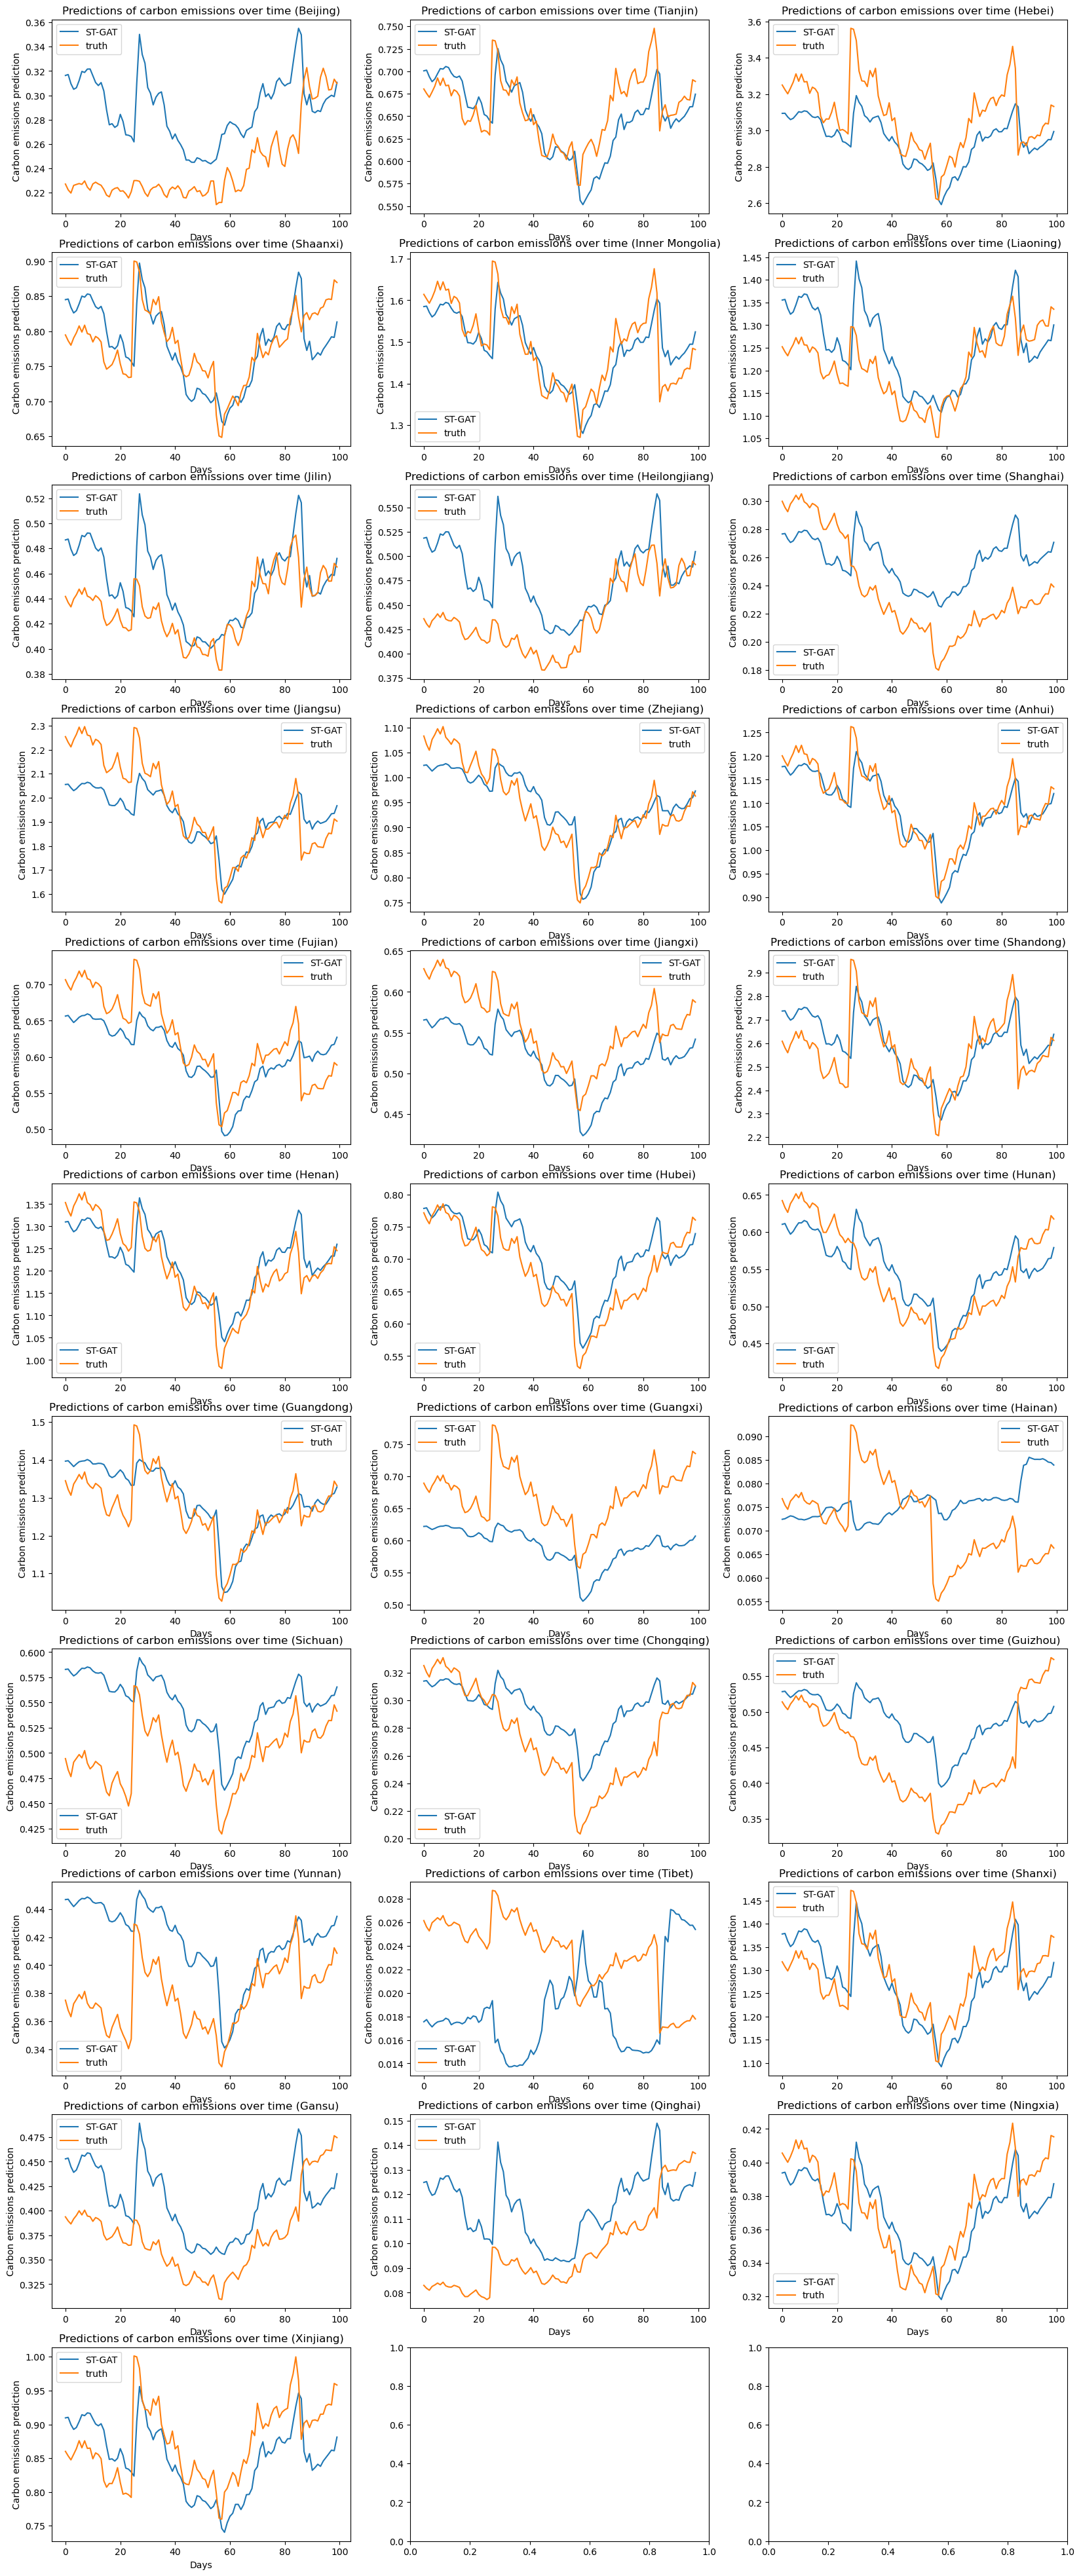

In [55]:
def plot_predictions(test_dataloader, y_pred, y_truth, node_names, config):
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    
    fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(20, 50))
    node = 0
    
    # Loop through each row and column and plot the corresponding node's predictions
    for row in range(11):
        for col in range(3):
            if node >= config['N_NODE']:
                break
            y_truth_node = y_truth[:, :, node, 0].flatten()[:100]
            y_pred_node = y_pred[:, :, node, 0].flatten()[:100]
            t = [t for t in range(0, 100, 1)]
            axes[row, col].plot(t, y_pred_node, label='ST-GAT')
            axes[row, col].plot(t, y_truth_node, label='truth')
            axes[row, col].set_xlabel('Days')
            axes[row, col].set_ylabel('Carbon emissions prediction')
            axes[row, col].set_title(f'Predictions of carbon emissions over time ({node_names[node]})')
            axes[row, col].legend()
            node += 1
    
    plt.savefig('results/predicted_times_grp.png')
    plt.show()
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_predictions(test_dataloader, y_pred, y_truth, node_names, config)

# Bibliography <a class="anchor" id="ref"></a>

Zhang, C., Yu, J. J. Q., & Liu, Y. (2019). Spatial-Temporal Graph Attention Networks: A Deep Learning Approach for Traffic Forecasting. IEEE Access, 7, 166246–166256. https://doi.org/10.1109/ACCESS.2019.2953888

Cao, Q., Liang, Y., & Niu, X. (2017). China’s Air Quality and Respiratory Disease Mortality Based on the Spatial Panel Model. International Journal of Environmental Research and Public Health, 14(9), 1081. https://doi.org/10.3390/ijerph14091081

